In [5]:
import os
os.chdir("../Scripts")

In [6]:
import gymnasium as gym
from agents.sample_averaging import ArmedBanditMaximizer
import matplotlib.pyplot as plt
from environments.simple import KArmedTestbed
import numpy as np

from tqdm.notebook import tqdm

gym.register(
    id="KArmedTestbed-V1",
    entry_point="environments.simple.KArmedTestbed",
    max_episode_steps=None
)

In [7]:
def average_tests(env, epsilon, step_size_type, num_tests, num_steps, step_size=0.1):
    test_averages = []
    for _ in tqdm(range(num_tests)):
        maximizer = ArmedBanditMaximizer(
            env=env,
            epsilon=epsilon,
            step_size_type=step_size_type
        )

        env.reset()
        maximizer.learn(num_steps=num_steps, progress_bar=False)

        test_averages.append(maximizer.average_rewards)
    
    return np.average(test_averages, axis=0)

# Stationary

In [ ]:
num_steps = 1000
step_size_type = "academic"
seed=42
num_arms = 10
num_tests = 2000

train_env = KArmedTestbed(k=num_arms,
                          stationary=True,
                          stochastic_reward=True,
                          reward_means=[0.25, -0.75, 1.5, 0.4, 1.25, -1.5, 0.1, -1, 1, -0.5],
                          reward_stds=np.ones(shape=(num_arms, ))
                          )

In [ ]:
greedy_rewards = average_tests(train_env, 0.0, step_size_type, num_tests, num_steps)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
epsilon_01_rewards = average_tests(train_env, 0.1, step_size_type, num_tests, num_steps)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
epsilon_001_rewards = average_tests(train_env, 0.01, step_size_type, num_tests, num_steps)

  0%|          | 0/2000 [00:00<?, ?it/s]

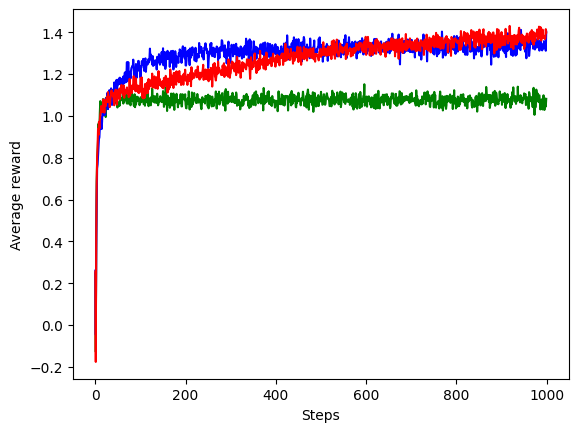

In [ ]:
fig, ax = plt.subplots()

ax.plot(greedy_rewards, color="green")
ax.plot(epsilon_01_rewards, color="blue")
ax.plot(epsilon_001_rewards, color="red")

ax.set_xlabel("Steps")
ax.set_ylabel("Average reward")

plt.show()

# Non-Stationary

In [8]:
num_steps = 10_000
num_tests = 2000
num_arms = 10
seed=42
epsilon=0.1

In [9]:
train_env = KArmedTestbed(
    k=num_arms,
    stationary=False,
    stochastic_reward=False
)

#### Incremental step-size

In [10]:
step_size_type = "academic"

In [11]:
incremental_step_rewards = average_tests(train_env, epsilon, step_size_type, num_tests, num_steps)

  0%|          | 0/2000 [00:00<?, ?it/s]

#### Constant step-size

In [12]:
step_size_type = "constant"
step_size = 0.1

In [13]:
constant_step_rewards = average_tests(train_env, epsilon, step_size_type, num_tests, num_steps, step_size)

  0%|          | 0/2000 [00:00<?, ?it/s]

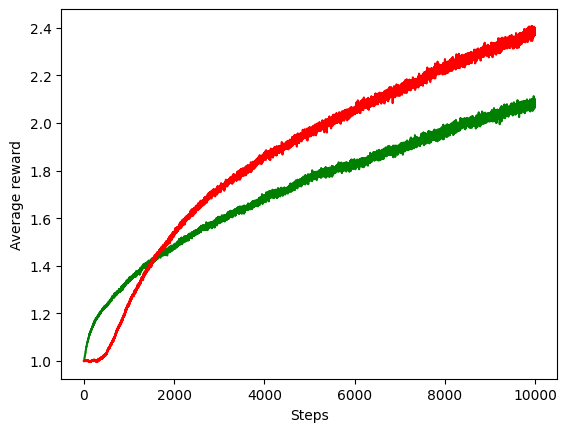

In [14]:
fig, ax = plt.subplots()

ax.plot(incremental_step_rewards, color="green")
ax.plot(constant_step_rewards, color="red")

ax.set_xlabel("Steps")
ax.set_ylabel("Average reward")

plt.show()

We conclude that first of all, non-stationarity significantly hardens the learning process as it introduces more stochasticity to the agent to deal with (curves reached an optimal policy on 200~400 steps when stationary while they struggle to find one even after 100_000 steps in non-stationary settings) and secondly even though for the first few steps the constant step-size struggles to do any "learning", it surpasses the efficiency of the incremental one and maximizes the reward.

The observations align with the challenges of non-stationary environments in reinforcement learning. The non-stationarity, introduced by the random walks in the q*(a) values, indeed increases stochasticity, making it harder for the agent to converge to an optimal policy, as seen by the slower progress compared to the stationary case (200-400 steps vs. struggling beyond 100,000 steps). Additionally, the constant step-size method (red curve) initially lags but eventually outperforms the incremental step-size method (green curve) in maximizing reward, likely due to its ability to adapt to the changing q-values over longer runs. This suggests that a constant step-size might be more robust for non-stationary problems with sufficient exploration (ε = 0.1).